In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import sys
sys.path.append("../")

import seaborn as sns
sns.set_style("white")

# sklearn imports
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# svm
from sklearn.svm import SVR

# gaussian process reg
import sklearn.gaussian_process as gp
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel

# scipy imports
from scipy.stats import zscore

import src.linear_regression as lr


In [2]:
df_wmt = pd.read_pickle("../data/wmt21_processed_data.pkl")

In [3]:
# drop columns with ref- label. 
df_wmt.drop(df_wmt[df_wmt["model"].apply(lambda x : "ref-" in x)].index, inplace=True) 

In [4]:
max_bleu_scores = df_wmt.groupby(["dataset", "langpair"])["bleu"].max()
df_wmt_joined = df_wmt.join(max_bleu_scores, on=["dataset", "langpair"], rsuffix="_max")

In [5]:
# gather models with best performances
best_performances = df_wmt[df_wmt_joined["bleu"] == df_wmt_joined["bleu_max"]]

In [6]:
train, test = train_test_split(df_wmt, test_size=0.15) 

# 1. Linear regression with just URIEL features

- train simple linear regression model with URIEL features
- plot bootstrapped sample coefficients (vertical line = coefficient of linear regression with all data)
- get feature importances

In [7]:
pipeline = lr.build_simple_regression_pipeline()
pipelines = lr.bootstrap_train(train, pipeline, lr.metrics, lr.uriel_features)
pipeline_population = lr.train_regression(train, pipeline, lr.metrics, lr.uriel_features)
coefficients = lr.gather_coefficients(pipelines, lr.metrics, lr.uriel_features)


### 1.1 BLEU score bootstrapped coefficients

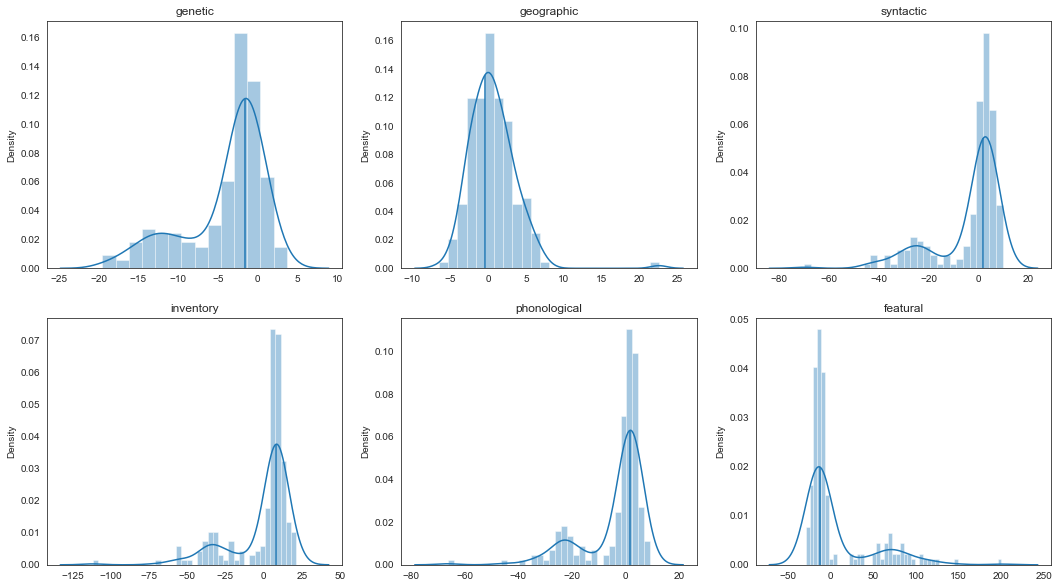

In [8]:
population_val = pipeline_population["regression"].coef_[0]

fig, axs = plt.subplots(2,3,figsize=(18, 10))
i=0

for feat, ax in zip(lr.uriel_features, axs.ravel()):
    sns.distplot(coefficients["bleu"][feat], ax=ax) 
    kdeline = ax.lines[0]
    xs = kdeline.get_xdata()
    ys = kdeline.get_ydata()
    height = np.interp(population_val[i], xs, ys)
    ax.vlines(population_val[i],0,height)
    ax.set_title(feat)
    i+=1
    
plt.show()

### 1.2 Mover score bootstrapped coefficients

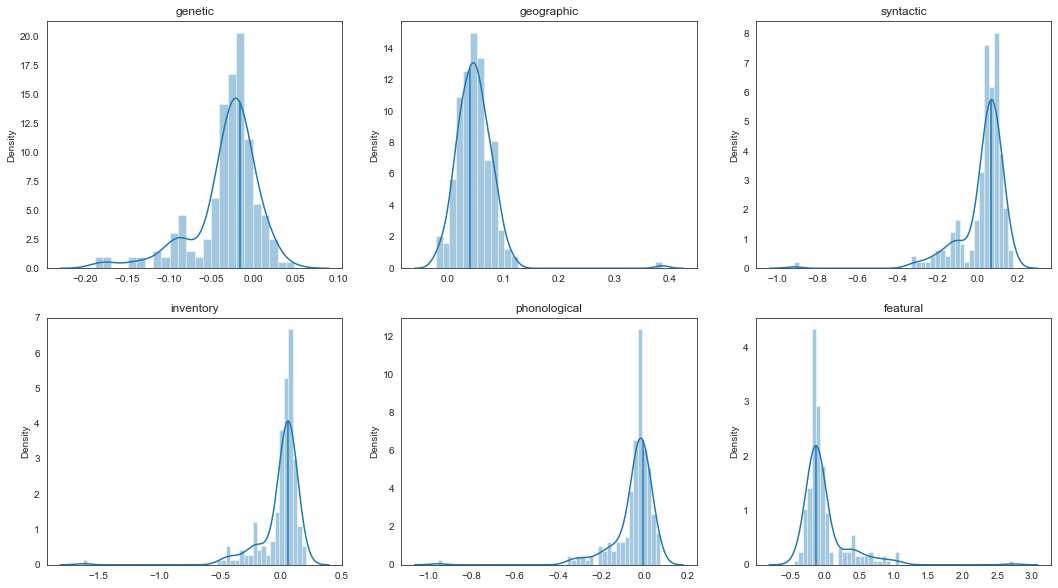

In [9]:
population_val = pipeline_population["regression"].coef_[2]

fig, axs = plt.subplots(2,3,figsize=(18, 10))
i=0

for feat, ax in zip(lr.uriel_features, axs.ravel()):
    sns.distplot(coefficients["mover_score"][feat], ax=ax) 
    kdeline = ax.lines[0]
    xs = kdeline.get_xdata()
    ys = kdeline.get_ydata()
    height = np.interp(population_val[i], xs, ys)
    ax.vlines(population_val[i],0,height)
    ax.set_title(feat)
    i+=1
    
plt.show()

### 1.3 ROUGE2 score bootstrapped coefficients

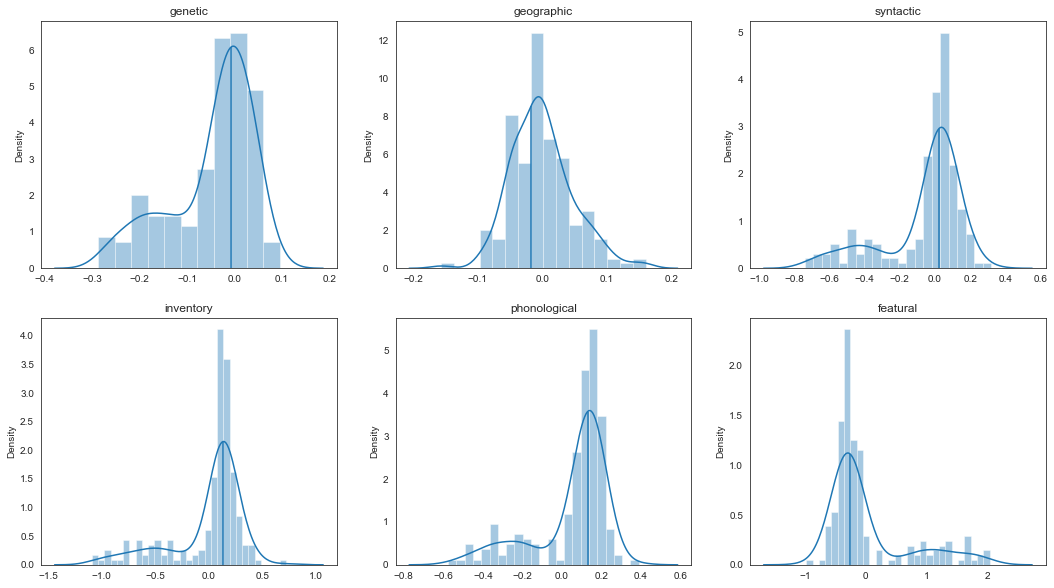

In [10]:
population_val = pipeline_population["regression"].coef_[1]

fig, axs = plt.subplots(2,3,figsize=(18, 10))
i=0

for feat, ax in zip(lr.uriel_features, axs.ravel()):
    sns.distplot(coefficients["rouge2"][feat], ax=ax) 
    kdeline = ax.lines[0]
    xs = kdeline.get_xdata()
    ys = kdeline.get_ydata()
    height = np.interp(population_val[i], xs, ys)
    ax.vlines(population_val[i],0,height)
    ax.set_title(feat)
    i+=1
    
plt.show()

With just URIEL distances, bootstrapping shows that the coefficients are not so normal. may explain poor/unstable fit? also, wanted to see how this changes if we add more features

### 1.4 MSE and R2 score

In [11]:
lr.print_results(pipeline_population, lr.uriel_features, test)

for metric: bleu, mse error: 84.17313110576632, r2 score: 0.017248639033662028
for metric: rouge2, mse error: 0.02348040096271525, r2 score: 0.010258113600099095
for metric: mover_score, mse error: 0.008750039484529225, r2 score: -0.016792608043253887


In [12]:
importances = lr.feature_importances(pipeline_population, lr.uriel_features)

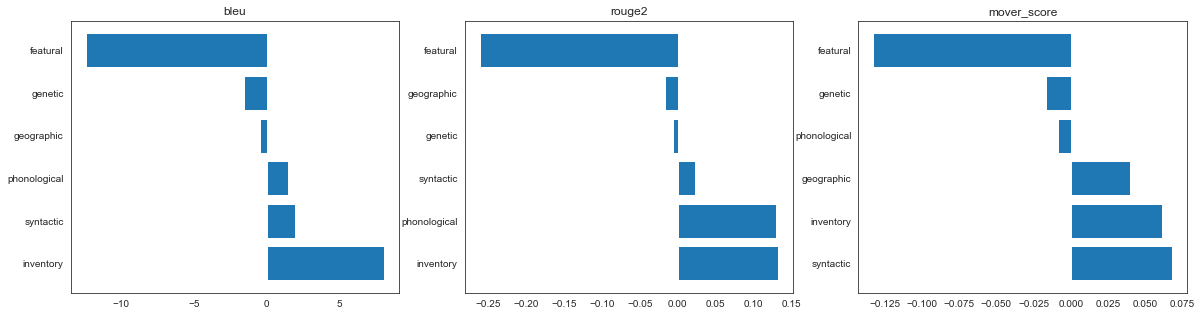

In [13]:
fig, axs = plt.subplots(1,3,figsize=(20, 5))

for metric, ax in zip(lr.metrics, axs.ravel()):
    ax.barh(importances[metric]["features"], importances[metric]["importance_vals"])
    ax.set_title(metric)
    
plt.show()

# 2. Linear regression with all features

- train simple linear regression model with URIEL features
- plot bootstrapped sample coefficients (vertical line = coefficient of linear regression with all data)
- get feature importances

In [14]:
lr.all_features

['genetic',
 'geographic',
 'syntactic',
 'inventory',
 'phonological',
 'featural',
 'source_ttr',
 'target_ttr',
 'data_size',
 'ttr_distance']

In [15]:
features = ['genetic',
 'geographic',
 'syntactic',
 'inventory',
 'phonological',
 'featural',
 'source_ttr',
 'target_ttr',
 'ttr_distance'
]
# excluded data_size

In [16]:


pipeline = lr.build_simple_regression_pipeline()
pipelines = lr.bootstrap_train(train, pipeline, lr.metrics, features)
pipeline_population = lr.train_regression(train, pipeline, lr.metrics, features)
coefficients = lr.gather_coefficients(pipelines, lr.metrics, features)


### 2.1 BLEU score bootstrapped coefficients

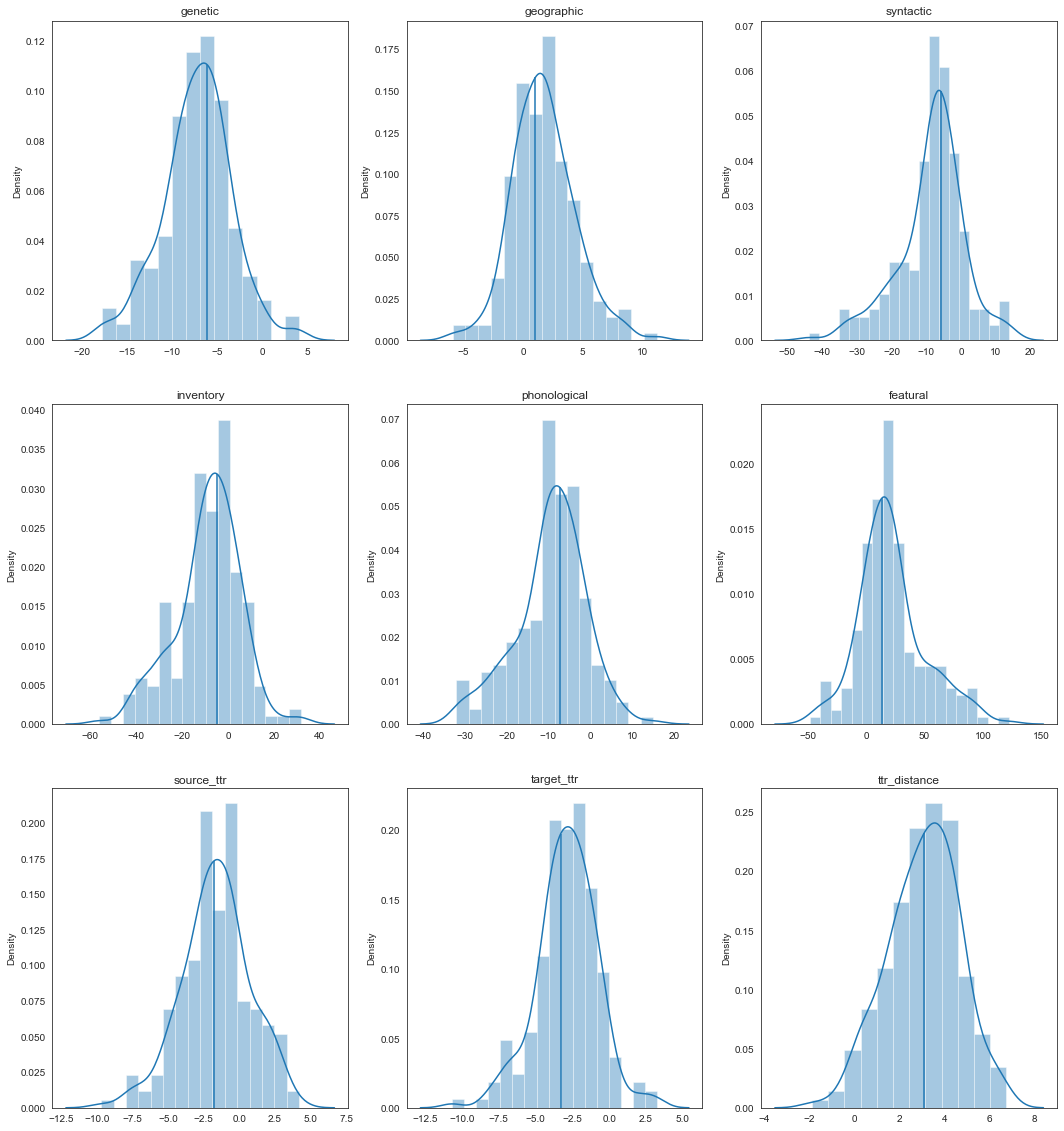

In [17]:
population_val = pipeline_population["regression"].coef_[0]
fig, axs = plt.subplots(3,3,figsize=(18, 20))
i=0

for feat, ax in zip(features, axs.ravel()):
    sns.distplot(coefficients["bleu"][feat], ax=ax) 
    kdeline = ax.lines[0]
    xs = kdeline.get_xdata()
    ys = kdeline.get_ydata()
    height = np.interp(population_val[i], xs, ys)
    ax.vlines(population_val[i],0,height)
    ax.set_title(feat)
    i+=1
    
plt.show()

### 2.2 Mover score bootstrapped coefficients

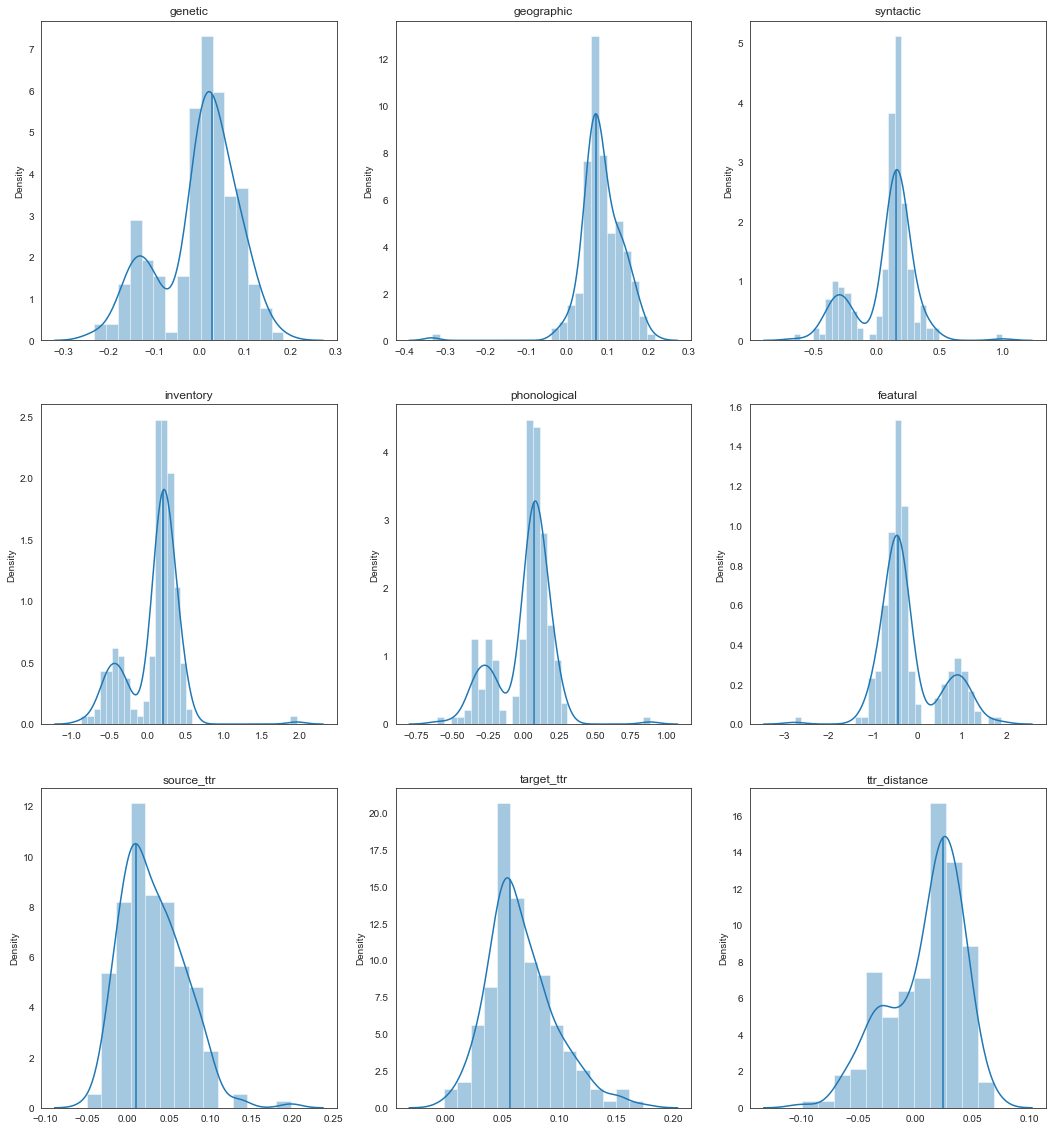

In [18]:
population_val = pipeline_population["regression"].coef_[2]
fig, axs = plt.subplots(3,3,figsize=(18, 20))
i=0

for feat, ax in zip(features, axs.ravel()):
    sns.distplot(coefficients["mover_score"][feat], ax=ax) 
    kdeline = ax.lines[0]
    xs = kdeline.get_xdata()
    ys = kdeline.get_ydata()
    height = np.interp(population_val[i], xs, ys)
    ax.vlines(population_val[i],0,height)
    ax.set_title(feat)
    i+=1
    
plt.show()

### 2.3 ROUGE2 score bootstrapped coefficients

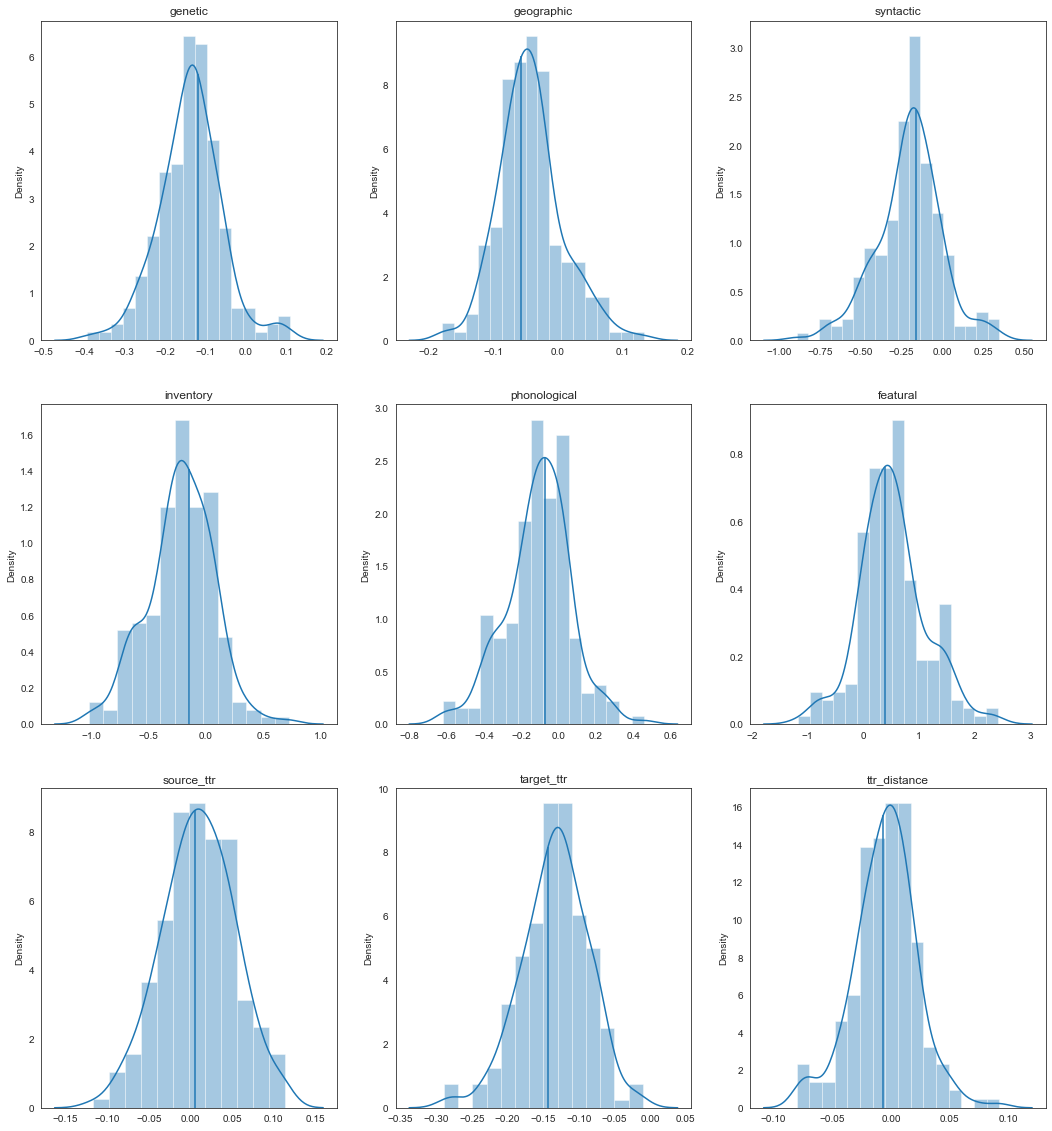

In [19]:
population_val = pipeline_population["regression"].coef_[1]
fig, axs = plt.subplots(3,3,figsize=(18, 20))
i=0

for feat, ax in zip(features, axs.ravel()):
    sns.distplot(coefficients["rouge2"][feat], ax=ax) 
    kdeline = ax.lines[0]
    xs = kdeline.get_xdata()
    ys = kdeline.get_ydata()
    height = np.interp(population_val[i], xs, ys)
    ax.vlines(population_val[i],0,height)
    ax.set_title(feat)
    i+=1
    
plt.show()

They seemed to look more gaussian in distribution than just with uriel dataset.

In [20]:
lr.print_results(pipeline_population, features, test)

for metric: bleu, mse error: 118.24142346512404, r2 score: -0.38051083886776405
for metric: rouge2, mse error: 0.04439902954042497, r2 score: -0.8715003769076839
for metric: mover_score, mse error: 0.014869212557137825, r2 score: -0.7278671076002698


In [21]:
importances = lr.feature_importances(pipeline_population, features)

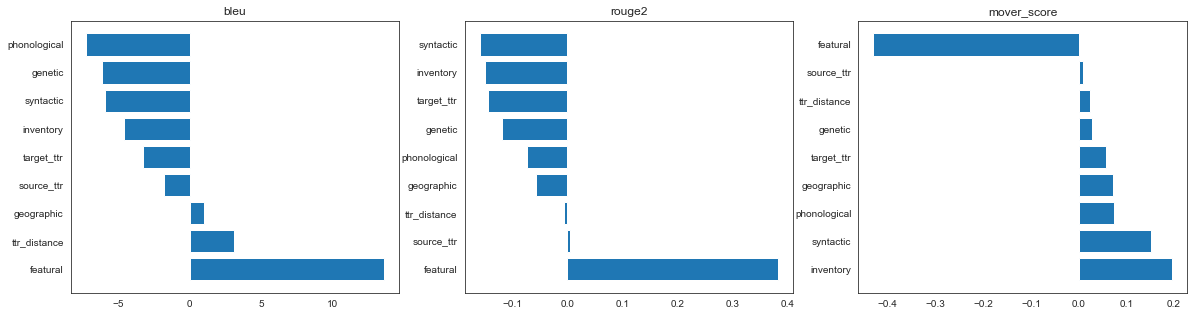

In [22]:
fig, axs = plt.subplots(1,3,figsize=(20, 5))

for metric, ax in zip(lr.metrics, axs.ravel()):
    ax.barh(importances[metric]["features"], importances[metric]["importance_vals"])
    ax.set_title(metric)
    
plt.show()

MSE/R2 scores are *still* really bad for simple regression after adding more data features. Tried polynomial regression and basis expanded regression, and the performances were similarly bad. I think there might be some issues with data preprocessing. Few problems I can think of:
- type token ratio calculation doesn't take into account pretrained models. I just calculated them from training datasets available on WMT21 drive
- data size was excluded as a feature in this. they seem to make the performance significantly worse.
- for type token ratio calculation, i used word tokenizers by language. maybe that's not the right thing to do?

### Polynomial Regression

In [36]:
degrees = [1,2,3,4,5,6]


for degree in degrees:
    print("--++--")
    print("degree: {}".format(degree))
    
    pipeline=lr.build_polynomial_regression_pipeline(degree)
    lr.train_regression(train, pipeline, lr.metrics, features)
    lr.print_results(pipeline, features, test)
    print("--++--\n\n")
    


--++--
degree: 1
for metric: bleu, mse error: 118.24142346512376, r2 score: -0.3805108388677607
for metric: rouge2, mse error: 0.04439902954042474, r2 score: -0.8715003769076743
for metric: mover_score, mse error: 0.014869212557137773, r2 score: -0.7278671076002636
--++--


--++--
degree: 2
for metric: bleu, mse error: 2.298974701666218e+28, r2 score: -2.6841350526104886e+26
for metric: rouge2, mse error: 2.055583294916343e+24, r2 score: -8.664659905907152e+25
for metric: mover_score, mse error: 7.682710724261437e+23, r2 score: -8.927643684323274e+25
--++--


--++--
degree: 3
for metric: bleu, mse error: 9.25100601839691e+24, r2 score: -1.0800879847826562e+23
for metric: rouge2, mse error: 1.195258877261345e+21, r2 score: -5.038234984979023e+22
for metric: mover_score, mse error: 9.171605016931482e+20, r2 score: -1.0657803546597476e+23
--++--


--++--
degree: 4
for metric: bleu, mse error: 142.55389351814836, r2 score: -0.6643676078768732
for metric: rouge2, mse error: 0.03246180936475

### Support Vector Regression and Gaussian Process Regression

i wanted to try using a model that can introduce non-linearity. Did not hyperparameter tune.
The performances (going by r2 score and MSE) were similarly bad, so linearity might not have been a big problem.

#### SVR

In [24]:
model = SVR(C=2.4, epsilon=2.6, kernel='sigmoid')
#model = SVR(C=2, epsilon=12, kernel='rbf')


In [25]:
model.fit(train[features], train["bleu"])

SVR(C=2.4, epsilon=2.6, kernel='sigmoid')

In [26]:
model.score(test[features], test["bleu"])

0.028927874716895396

In [27]:
test_pred = model.predict(test[features])

In [28]:
mean_squared_error(test_pred, test["bleu"])

83.17279890025985

In [29]:
y_pred = model.predict(test[features])

#### GPR

In [30]:
kernel = gp.kernels.ConstantKernel(1, (1e-1,1e3))*gp.kernels.RBF(10, (1e-3,1e3))
kernel = DotProduct() + WhiteKernel()

In [31]:
model = gp.GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, alpha=0.1, normalize_y=True)

In [32]:
model.fit(train[lr.uriel_features], train["bleu"])
params = model.kernel_.get_params()

In [33]:
y_pred, std = model.predict(test[lr.uriel_features], return_std=True)


In [34]:
mean_squared_error(y_pred, test["bleu"])

85.31594323719328

In [35]:
r2_score(y_pred, test["bleu"])

-185.49504483943085